### Imports For This Video

In [17]:
import io
import datetime as dt

import httpx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Function For Getting OHLC Data (we will only use volume)

In [2]:
def get_ohcl_data(ticker, date, expiration):
    BASE_URL = "http://localhost:25503/v3"
    
    params = {
        'date': date,
        'symbol': ticker,
        'expiration': expiration,
        'interval': '1m',
        'start_time': '00:00:00',
        'end_time': '23:59:59',
    }
    
    url = BASE_URL + '/option/history/ohlc'
    
    with httpx.Client(timeout=60) as client:
        response = client.get(url, params=params)
        response.raise_for_status()
    
    df = pd.read_csv(io.StringIO(response.text))

    return df

### Function For Getting Volume During Extended Hours

In [3]:
def get_extended_hours_volume(ticker, date, expiration):
    df = get_ohcl_data(ticker, date, expiration)

    df['time'] =  df['timestamp'].apply(lambda x: dt.datetime.fromisoformat(x).time())
    
    grouped_df = df.groupby(['right', 'time']).agg({'volume': 'sum'})
    grouped_df = grouped_df.reset_index()

    call_volume = grouped_df[(grouped_df.right == 'CALL') & ((grouped_df.time < dt.time(9,0,0)) | (grouped_df.time > dt.time(16,0,0)))].volume.sum()
    put_volume = grouped_df[(grouped_df.right == 'PUT') & ((grouped_df.time < dt.time(9,0,0)) | (grouped_df.time > dt.time(16,0,0)))].volume.sum()
    total_volume = call_volume + put_volume

    return call_volume, put_volume, total_volume

### Function For Checking If A Given Date Is Option Trading Day

In [4]:
def is_option_trading_day(date) -> bool:
    BASE_URL = "http://localhost:25503/v3"
    
    params = {
      'date': date,
      'format': 'json'
    }
    
    url = BASE_URL + '/calendar/on_date'
    
    with httpx.Client(timeout=60) as client:
        response = client.get(url, params=params)
        response.raise_for_status()

    return response.json()["type"][0] in ("open", "early_close")

### Relevant Expiration Dates
#### (Third Friday of each month which is standard monthly expiration date for many stock options)

In [5]:
# Third Friday of each month (standard monthly expiration date for many stock options)
relevant_expirations = [
    '2024-01-19',
    '2024-02-16',
    '2024-03-15',
    '2024-04-19',
    '2024-05-17',
    '2024-06-21',
    '2024-07-19',
    '2024-08-16',
    '2024-09-20',
    '2024-10-18',
    '2024-11-15',
    '2024-12-20',
    '2025-01-17'
]

### Craft DataFrame That Contains Volume From Extended Hours

In [6]:
start_date = dt.date(2024, 1, 1)
end_date = dt.date(2024, 12, 31)
delta = dt.timedelta(days=1)

data = []

while (start_date <= end_date):
    start_date += delta

    if is_option_trading_day(start_date):
        next_expiration = min(ed for ed in relevant_expirations if ed > start_date.isoformat())

        call_volume, put_volume, total_volume = get_extended_hours_volume('SPX', start_date, next_expiration)
        data.append({
            'date': start_date,
            'call_volume': call_volume,
            'put_volume': put_volume,
            'total_volume': total_volume,
        })

        print('Processed', start_date)

Processed 2024-01-02
Processed 2024-01-03
Processed 2024-01-04
Processed 2024-01-05
Processed 2024-01-08
Processed 2024-01-09
Processed 2024-01-10
Processed 2024-01-11
Processed 2024-01-12
Processed 2024-01-16
Processed 2024-01-17
Processed 2024-01-18
Processed 2024-01-19
Processed 2024-01-22
Processed 2024-01-23
Processed 2024-01-24
Processed 2024-01-25
Processed 2024-01-26
Processed 2024-01-29
Processed 2024-01-30
Processed 2024-01-31
Processed 2024-02-01
Processed 2024-02-02
Processed 2024-02-05
Processed 2024-02-06
Processed 2024-02-07
Processed 2024-02-08
Processed 2024-02-09
Processed 2024-02-12
Processed 2024-02-13
Processed 2024-02-14
Processed 2024-02-15
Processed 2024-02-16
Processed 2024-02-20
Processed 2024-02-21
Processed 2024-02-22
Processed 2024-02-23
Processed 2024-02-26
Processed 2024-02-27
Processed 2024-02-28
Processed 2024-02-29
Processed 2024-03-01
Processed 2024-03-04
Processed 2024-03-05
Processed 2024-03-06
Processed 2024-03-07
Processed 2024-03-08
Processed 202

In [7]:
data_df = pd.DataFrame(data)

In [8]:
data_df.to_csv('spx_extended_hours_volumes_2024.csv')

### Analyze 95th Percentile

In [9]:
data_df[data_df.put_volume > data_df.put_volume.quantile(0.95)]

,date,call_volume,put_volume,total_volume
11,2024-01-18,14008,19052,33060
29,2024-02-13,3711,17888,21599
46,2024-03-08,10734,20632,31366
50,2024-03-14,12209,16819,29028
104,2024-05-31,8688,31122,39810
117,2024-06-20,11639,23606,35245
122,2024-06-27,783,19458,20241
136,2024-07-18,14120,18384,32504
148,2024-08-05,1853,44606,46459
200,2024-10-17,12968,21039,34007


In [10]:
data_df['total_volume_q95'] = data_df['total_volume'].expanding().quantile(0.95)

In [11]:
data_df[data_df.total_volume > data_df.total_volume_q95]

,date,call_volume,put_volume,total_volume,total_volume_q95
1,2024-01-03,9872,9524,19396,18791.85
10,2024-01-17,6853,15324,22177,20786.50
11,2024-01-18,14008,19052,33060,27074.35
31,2024-02-15,15629,14725,30354,25856.65
46,2024-03-08,10734,20632,31366,27900.90
104,2024-05-31,8688,31122,39810,28560.80
117,2024-06-20,11639,23606,35245,29028.00
136,2024-07-18,14120,18384,32504,29028.00
148,2024-08-05,1853,44606,46459,29028.00
200,2024-10-17,12968,21039,34007,27542.00


### Plotting Extended Hours Volume

In [12]:
plt.style.use('bmh')

In [13]:
data_df['SMA30'] = data_df.total_volume.rolling(window=30).mean()
data_df['bar_color'] = data_df.date.apply(lambda x: '#ff6666' if x in relevant_expirations else '#00aaff')

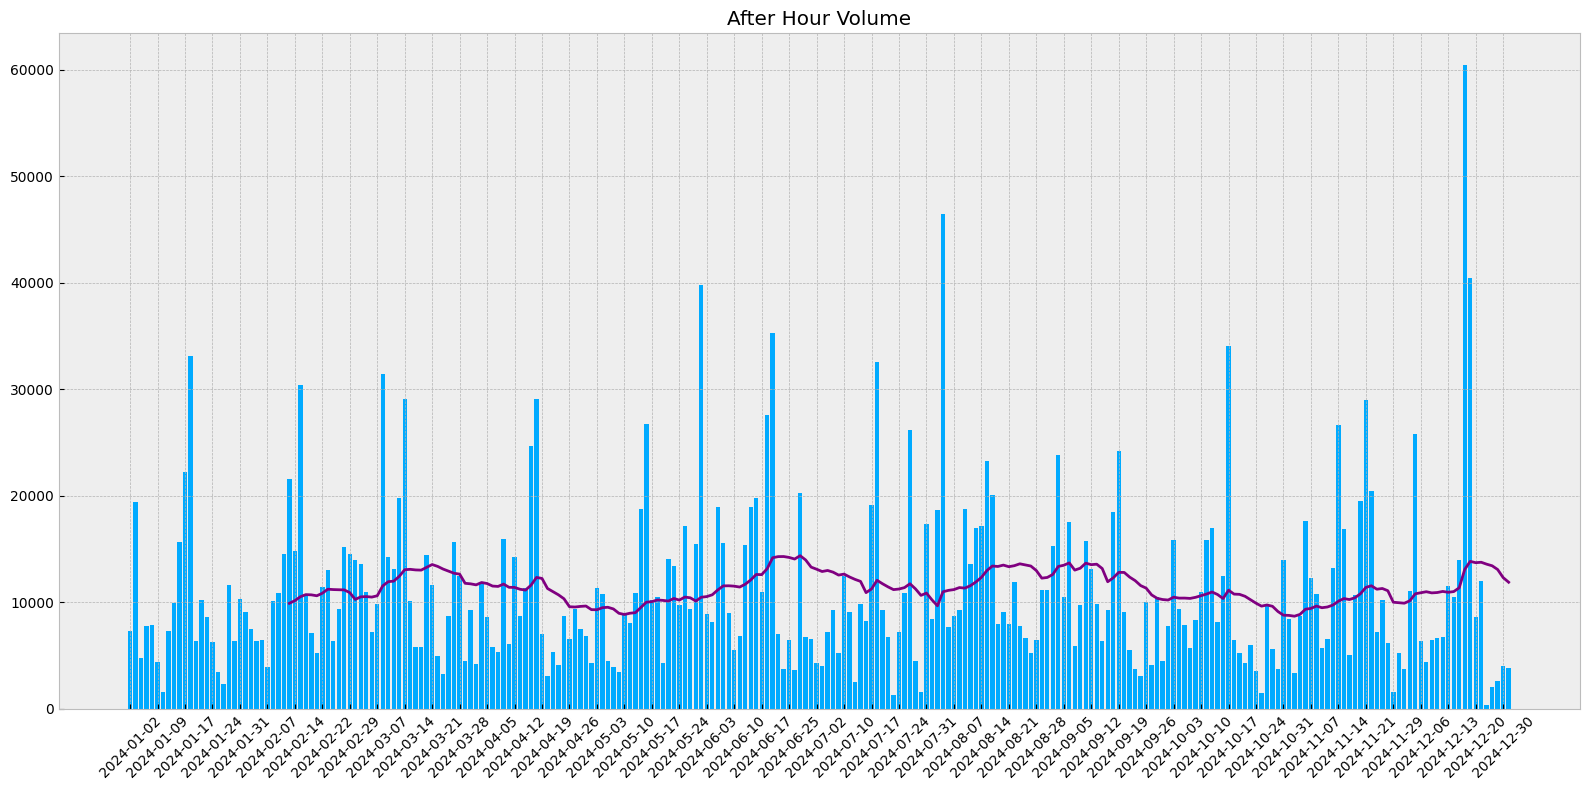

In [14]:
plt.figure(figsize=(16,8))
plt.bar(range(len(data_df)), data_df.total_volume, color=data_df.bar_color)
plt.plot(data_df['SMA30'], color='purple')

step = 5
indices = range(0, len(data_df), step)

plt.xticks(indices, data_df.date.iloc[indices], rotation=45)
plt.title('After Hour Volume')

plt.tight_layout()
plt.show()

### Plotting CALL and PUT Volumes Separately

In [15]:
data_df['put_back'] = data_df.apply(lambda x: x['put_volume'] > x['call_volume'], axis=1)
data_df['SMA30_PUT'] = data_df.put_volume.rolling(window=30).mean()
data_df['SMA30_CALL'] = data_df.call_volume.rolling(window=30).mean()

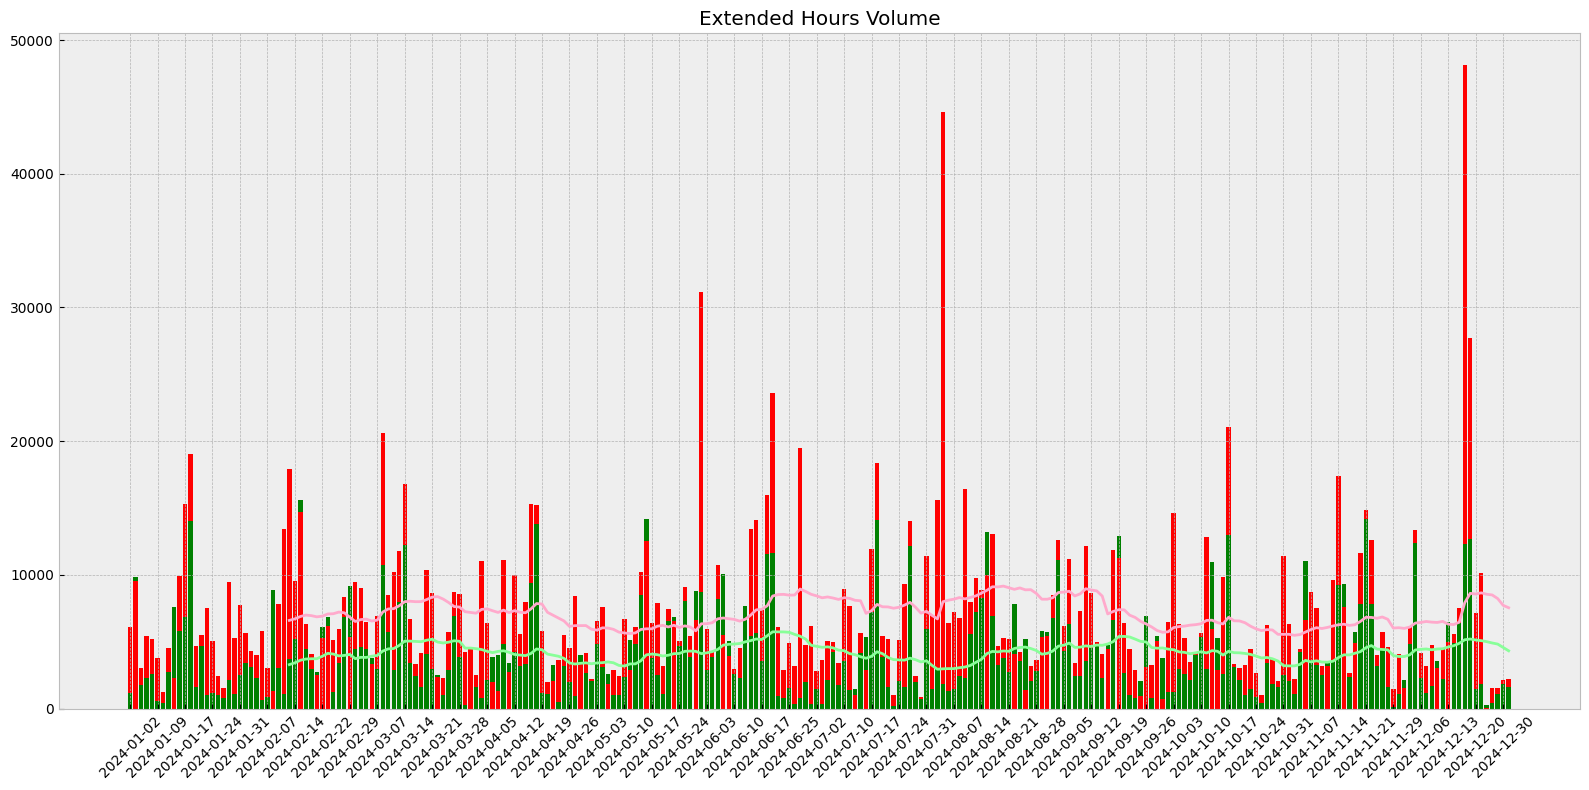

In [19]:
x = np.arange(len(data_df))

plt.figure(figsize=(16,8))

plt.bar(x[data_df.put_back],  data_df.put_volume[data_df.put_back],  color='red')
plt.bar(x[data_df.put_back],  data_df.call_volume[data_df.put_back], color='green')

plt.bar(x[~data_df.put_back], data_df.call_volume[~data_df.put_back], color='green')
plt.bar(x[~data_df.put_back], data_df.put_volume[~data_df.put_back],  color='red')

plt.plot(x, data_df['SMA30_PUT'], color='#ffaacc')
plt.plot(x, data_df['SMA30_CALL'], color='#88ff99')

step = 5
indices = range(0, len(data_df), step)
plt.xticks(indices, data_df.date.iloc[indices], rotation=45)
plt.title('Extended Hours Volume')

plt.tight_layout()
plt.show()

### Analyzing Full Volume VS Open Interest

In [20]:
def get_full_volume(ticker, date, expiration):
    df = get_ohcl_data(ticker, date, expiration)

    df['time'] =  df['timestamp'].apply(lambda x: dt.datetime.fromisoformat(x).time())
    
    grouped_df = df.groupby(['right', 'time']).agg({'volume': 'sum'})
    grouped_df = grouped_df.reset_index()

    call_volume = grouped_df[grouped_df.right == 'CALL'].volume.sum()
    put_volume = grouped_df[grouped_df.right == 'PUT'].volume.sum()
    total_volume = call_volume + put_volume

    return call_volume, put_volume, total_volume

In [21]:
def get_open_interest_data(ticker, date, expiration):
    BASE_URL = "http://localhost:25503/v3"

    params = {
      'date': date,
      'symbol': ticker,
      'expiration': expiration,
    }

    url = BASE_URL + '/option/history/open_interest'

    with httpx.Client(timeout=60) as client:
        response = client.get(url, params=params)
        response.raise_for_status()

    df = pd.read_csv(io.StringIO(response.text))

    return df

In [22]:
def get_open_interest(ticker, date, expiration):
    df = get_open_interest_data(ticker, date, expiration)

    df['time'] =  df['timestamp'].apply(lambda x: dt.datetime.fromisoformat(x).time())
    
    grouped_df = df.groupby(['right']).agg({'open_interest': 'sum'})
    grouped_df = grouped_df.reset_index()

    calls_open = grouped_df[grouped_df.right == 'CALL'].open_interest.sum()
    puts_open = grouped_df[grouped_df.right == 'PUT'].open_interest.sum()
    total_open = calls_open + puts_open

    return calls_open, puts_open, total_open

### Craft DataFrame with Full Volume and Open Interest

In [23]:
start_date = dt.date(2024, 1, 1)
end_date = dt.date(2024, 12, 31)
delta = dt.timedelta(days=1)

data2 = []

while (start_date <= end_date):
    start_date += delta

    if is_option_trading_day(start_date):
        next_expiration = min(ed for ed in relevant_expirations if ed > start_date.isoformat())

        call_volume, put_volume, total_volume = get_full_volume('SPX', start_date, next_expiration)
        calls_open, puts_open, total_open = get_open_interest('SPX', start_date, next_expiration)
        
        data2.append({
            'date': start_date,
            'call_volume': call_volume,
            'put_volume': put_volume,
            'total_volume': total_volume,
            'calls_open': calls_open,
            'puts_open': puts_open,
            'total_open': total_open,
        })

        print('processed', start_date)

processed 2024-01-02
processed 2024-01-03
processed 2024-01-04
processed 2024-01-05
processed 2024-01-08
processed 2024-01-09
processed 2024-01-10
processed 2024-01-11
processed 2024-01-12
processed 2024-01-16
processed 2024-01-17
processed 2024-01-18
processed 2024-01-19
processed 2024-01-22
processed 2024-01-23
processed 2024-01-24
processed 2024-01-25
processed 2024-01-26
processed 2024-01-29
processed 2024-01-30
processed 2024-01-31
processed 2024-02-01
processed 2024-02-02
processed 2024-02-05
processed 2024-02-06
processed 2024-02-07
processed 2024-02-08
processed 2024-02-09
processed 2024-02-12
processed 2024-02-13
processed 2024-02-14
processed 2024-02-15
processed 2024-02-16
processed 2024-02-20
processed 2024-02-21
processed 2024-02-22
processed 2024-02-23
processed 2024-02-26
processed 2024-02-27
processed 2024-02-28
processed 2024-02-29
processed 2024-03-01
processed 2024-03-04
processed 2024-03-05
processed 2024-03-06
processed 2024-03-07
processed 2024-03-08
processed 202

In [24]:
data2_df = pd.DataFrame(data2)

In [25]:
data2_df.to_csv('spx_volume_and_open_interest_2024.csv')

In [26]:
data2_df['volume_to_open'] = data2_df['total_volume'] / data2_df['total_open']

### Analyze 95th Percentile of Volume To Open Interest Ratio

In [27]:
data2_df[data2_df.volume_to_open > data2_df.volume_to_open.quantile(0.95)]

,date,call_volume,put_volume,total_volume,calls_open,puts_open,total_open,volume_to_open
11,2024-01-18,180628,200766,381394,925789,1874391,2800180,0.136203
12,2024-01-19,120000,155629,275629,528605,1109380,1637985,0.168273
31,2024-02-15,145649,155306,300955,632622,1423174,2055796,0.146393
54,2024-03-20,71538,177672,249210,629064,1179938,1809002,0.137761
73,2024-04-17,126674,155391,282065,733318,1397076,2130394,0.132400
74,2024-04-18,135394,170819,306213,733484,1415773,2149257,0.142474
75,2024-04-19,77023,140032,217055,489566,1134988,1624554,0.133609
94,2024-05-16,132797,129655,262452,617551,1274351,1891902,0.138724
136,2024-07-18,156687,240627,397314,676892,1517904,2194796,0.181025
147,2024-08-02,66392,208154,274546,598748,1284250,1882998,0.145803
